In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from xgcm import Grid

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Reading in data for parameterized runs:

In [31]:
#/neerajab/NeverWorld2/runGM/run1 has KHTH=100
#/neerajab/NeverWorld2/runGM/run3 has KHTH=500
#/neerajab/NeverWorld2/runGM/run6 has KHTH=2500
#/neerajab/NeverWorld2/runGM/run7 has KHTH=5000

#TUNED VERSIONS:
#/gmarques/NeverWorld2/Visbeck/nw2_0.5deg_N15_Visbeck_run3      TUNED! has Visbeck scheme on
#/gmarques/NeverWorld2/GEOMETRIC/nw2_0.5deg_N15_GEOMETRIC_run3  TUNED! has Geometric scheme (Marshall et al. 2012)
#/gmarques/NeverWorld2/TMEKE/nw2_0.5deg_N15_TMEKE_run3          TUNED! has MEKE+GM from Jansen et al. (topographic beta in rhines scale=topographic MEKE)

#not working or untuned:
#/gmarques/NeverWorld2/DM07/nw2_0.5deg_N15_DM07_run2           !NOT TUNED has Danabasoglu & Marshall 2007 stratification based scheme on
#/gmarques/NeverWorld2/nw2_0.5deg_N15_MEKE_OM4                 has OM4_p5 settings except FGNV is off...
#/gmarques/NeverWorld2/nw2_0.5deg_N15_QG_Leith  has QG Leith scheme on but not working?


%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/TMEKE/nw2_0.5deg_N15_TMEKE_run3 

fs=xr.open_dataset('static.nc', decode_times=False)
os=xr.open_dataset('ocean.stats.nc', decode_times=False)
#av=xr.open_dataset('averages_00028502.nc',decode_times=False)
av=xr.open_dataset('averages_00031502.nc',decode_times=False)

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/scratch/gmarques/NW2_TMP/nw2_0.5deg_N15_TMEKE_run3
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


## Reading in data for truth case:

In [41]:
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.03125deg_N15_baseline/
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_dataset('ocean.stats.nc', decode_times=False)
# av = xr.open_dataset('averages_00001202.nc', decode_times=False)
# %cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/


%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.25deg_N15_baseline/
fs = xr.open_dataset('static.nc', decode_times=False)
os = xr.open_dataset('ocean.stats.nc', decode_times=False)
av = xr.open_dataset('averages_00031502.nc', decode_times=False)  
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/


/glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.25deg_N15_baseline
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [42]:
%%time
xh = fs.xh.values
yh = fs.yh.values
# #COMPUTE velocity components for decomposing KE:
Nlayers=15

grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
h  = av['h'].mean('time').fillna(0.)
Depth=h.sum('zl')
print('done part 1')
#Outputs are comprised of 100 5-day averages.
u  = av['u'];  u = grid.interp(u,axis='X')#.fillna(0.); 
ubar=u.mean('time')
print('done part 2')
v  = av['v'];  v = grid.interp(v,axis='Y')#.fillna(0.);
vbar=v.mean('time')

uprime=u-ubar
vprime=v-vbar

print(uprime.shape)
area_t=fs['area_t']

done part 1
done part 2
(100, 15, 560, 240)
CPU times: user 10.4 s, sys: 6.01 s, total: 16.4 s
Wall time: 49.9 s


In [43]:
%%time
# The mean BT and BC KE values:
ubar_TW=ubar*h/Depth; 
ubar_BT=ubar_TW.sum('zl')
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth
vbar_BT=vbar_TW.sum('zl')
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT**2+ubar_BT**2) #dim y,x
KE_mean_BC=(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth).sum('zl') #dim y,x

print('done 1')

#Eddy BT and BC KE parts:
uprime_BT=(uprime*h/Depth).sum('zl')
uprime_BC=uprime-uprime_BT
vprime_BT=(vprime*h/Depth).sum('zl')
vprime_BC=vprime-vprime_BT
    
KE_eddy_BT=(0.5*(vprime_BT**2+uprime_BT**2)).mean('time')
KE_eddy_BC=((0.5*(vprime_BC**2+uprime_BC**2)*h/Depth).sum('zl')).mean('time')


# #Total kinetic energy:
KE_BT_tot=KE_eddy_BT+KE_mean_BT
KE_BC_tot=KE_eddy_BC+KE_mean_BC
KE_tot=KE_BT_tot+KE_BC_tot


fraction_BT=KE_BT_tot/KE_tot
fraction_BT_mean=KE_mean_BT/KE_tot
fraction_BT_eddy=KE_eddy_BT/KE_tot

fraction_BC=KE_BC_tot/KE_tot #when you divide zero/zero it's a nan
fraction_BC_mean=KE_mean_BC/KE_tot
fraction_BC_eddy=KE_eddy_BC/KE_tot

#KE_eddy = KE_eddy_BT+ KE_eddy_BC
#KE_mean = KE_mean_BT+ KE_eddy_BC

done 1
CPU times: user 2.82 s, sys: 2.88 s, total: 5.7 s
Wall time: 5.69 s


In [44]:
fraction_BT_025=fraction_BT
fraction_BC_025=fraction_BC
yh_025 = yh
print('done')

done


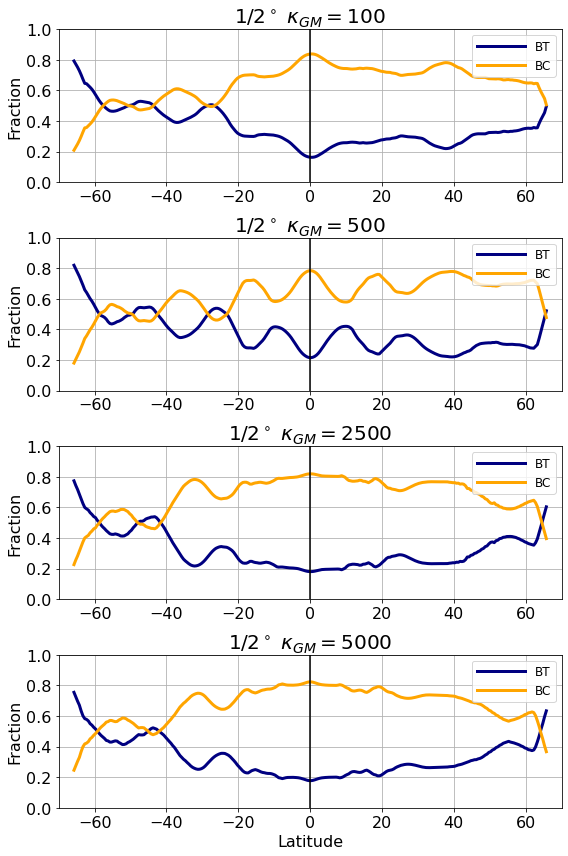

In [22]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=15

plt.subplots(4,figsize=(8, 12), facecolor='w', edgecolor='k') #dpi=100

plt.subplot(4,1,1)
plt.grid()
plt.plot(yh_lr,np.convolve((fraction_BT_GM100.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3); 
plt.plot(yh_lr,np.convolve((fraction_BC_GM100.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
plt.legend(['BT','BC'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.ylabel('Fraction',fontsize=16)
plt.title('1/2$^\circ$ $\kappa_{GM}=100$',fontsize=20)

plt.subplot(4,1,2)
plt.grid()
plt.plot(yh_lr,np.convolve((fraction_BT_GM500.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3); 
plt.plot(yh_lr,np.convolve((fraction_BC_GM500.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
plt.legend(['BT','BC'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.ylabel('Fraction',fontsize=16)
plt.title('1/2$^\circ$ $\kappa_{GM}=500$',fontsize=20)

plt.subplot(4,1,3)
plt.grid()
plt.plot(yh_lr,np.convolve((fraction_BT_GM2500.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3); 
plt.plot(yh_lr,np.convolve((fraction_BC_GM2500.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
plt.legend(['BT','BC'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.ylabel('Fraction',fontsize=16)
plt.title('1/2$^\circ$ $\kappa_{GM}=2500$',fontsize=20)

plt.subplot(4,1,4)
plt.grid()
plt.plot(yh_lr,np.convolve((fraction_BT_GM5000.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3); 
plt.plot(yh_lr,np.convolve((fraction_BC_GM5000.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
plt.legend(['BT','BC'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.ylabel('Fraction',fontsize=16)
plt.title('1/2$^\circ$ $\kappa_{GM}=5000$',fontsize=20)
plt.xlabel('Latitude',fontsize=16)

plt.tight_layout()

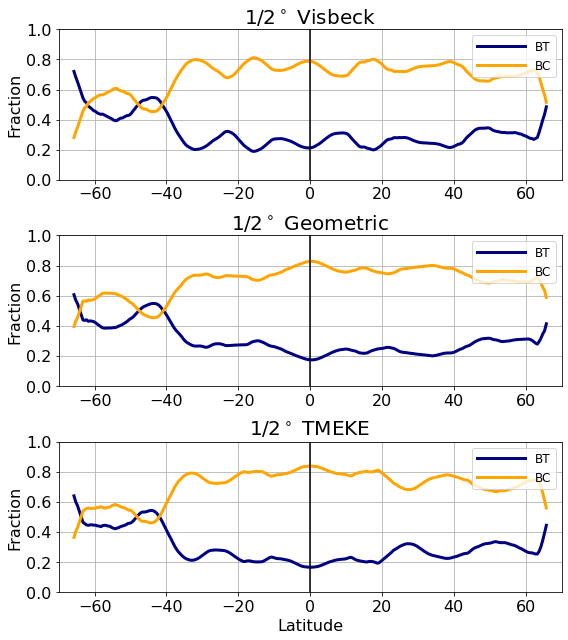

In [36]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=15

plt.subplots(4,figsize=(8, 9), facecolor='w', edgecolor='k') #dpi=100

plt.subplot(3,1,1)
plt.grid()
plt.plot(yh_lr,np.convolve((fraction_BT_Visbeck.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3); 
plt.plot(yh_lr,np.convolve((fraction_BC_Visbeck.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
plt.legend(['BT','BC'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.ylabel('Fraction',fontsize=16)
plt.title('1/2$^\circ$ Visbeck',fontsize=20)

plt.subplot(3,1,2)
plt.grid()
plt.plot(yh_lr,np.convolve((fraction_BT_GEOM.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3); 
plt.plot(yh_lr,np.convolve((fraction_BC_GEOM.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
plt.legend(['BT','BC'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.ylabel('Fraction',fontsize=16)
plt.title('1/2$^\circ$ Geometric',fontsize=20)


plt.subplot(3,1,3)
plt.grid()
plt.plot(yh_lr,np.convolve((fraction_BT_TMEKE.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3); 
plt.plot(yh_lr,np.convolve((fraction_BC_TMEKE.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
plt.legend(['BT','BC'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.ylabel('Fraction',fontsize=16)
plt.title('1/2$^\circ$ TMEKE',fontsize=20)
plt.xlabel('Latitude',fontsize=16)

plt.tight_layout()

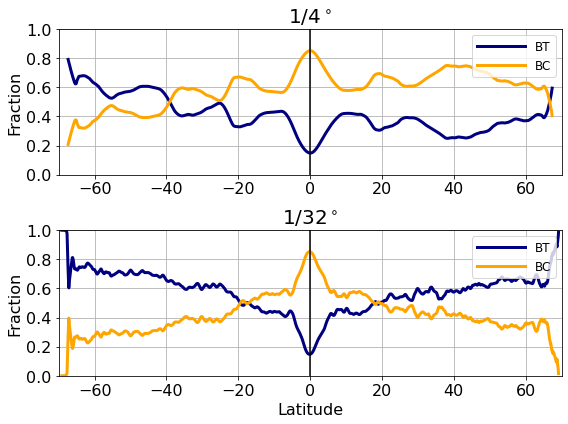

In [45]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=15

plt.subplots(4,figsize=(8, 6), facecolor='w', edgecolor='k') #dpi=100

plt.subplot(2,1,1)
plt.grid()
plt.plot(yh_025,np.convolve((fraction_BT_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3); 
plt.plot(yh_025,np.convolve((fraction_BC_025.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
plt.legend(['BT','BC'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.ylabel('Fraction',fontsize=16)
plt.title('1/4$^\circ$',fontsize=20)



plt.subplot(2,1,2)
plt.grid()
plt.plot(yh_003125,np.convolve((fraction_BT_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c=[0,0,0.5],linewidth=3); 
plt.plot(yh_003125,np.convolve((fraction_BC_003125.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-',c='#FFA500',linewidth=3)
plt.legend(['BT','BC'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70); plt.xticks(fontsize=16);
plt.ylim(0,1); plt.yticks(fontsize=16);
plt.ylabel('Fraction',fontsize=16)
plt.title('1/32$^\circ$',fontsize=20)
plt.xlabel('Latitude',fontsize=16)

plt.tight_layout()

In [ ]:
# plt.plot(yh,np.convolve((fraction_BT_mean.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-.',c=[0,0,0.5],linewidth=3)
# plt.plot(yh,np.convolve((fraction_BT_eddy.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c=[0,0,0.5],linewidth=3)
# plt.plot(yh,np.convolve((fraction_BC_mean.mean('xh').compute()), np.ones((window,))/window, mode='same'),'-.',c='#FFA500',linewidth=3)
# plt.plot(yh,np.convolve((fraction_BC_eddy.mean('xh').compute()), np.ones((window,))/window, mode='same'),':',c='#FFA500',linewidth=3)
#plt.legend(['BT','BT mean','BT eddy','BC','BC mean','BC eddy'],loc='upper right',fontsize=12,handlelength=4)